# Определение токсичности текста

## Импорты

In [ ]:
!pip3 install gensim==3.8.1 emoji

     |████████████████████████████████| 24.2MB 128kB/s 
     |████████████████████████████████| 133kB 47.8MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import re
import torch
import nltk
import json
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from collections import OrderedDict
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm as tqdm_notebook
from nltk.tokenize import WordPunctTokenizer

nltk.download("punkt")

punct = punctuation+'«»—…“”*№–'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data_path = "/content/drive/MyDrive/thesis_datasets/toxic_dataset.csv"

test_data_path = '/content/drive/MyDrive/thesis_datasets/toxic_dataset_test.csv'
train_data_path = '/content/drive/MyDrive/thesis_datasets/toxic_dataset_train.csv'
valid_data_path = '/content/drive/MyDrive/thesis_datasets/toxic_dataset_valid.csv'

vector_model_path = "/content/drive/MyDrive/thesis_datasets/araneum_none_fasttextcbow_300_5_2018.model"

toxic_model_emj_best_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_model_emj_best.pth"
toxic_opt_emj_best_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_opt_emj_best.pth"
toxic_model_emj_last_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_model_emj_last.pth"
toxic_opt_emj_last_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_opt_emj_last.pth"

toxic_model_best_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_model_best.pth"
toxic_opt_best_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_opt_best.pth"
toxic_model_last_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_model_last.pth"
toxic_opt_last_state_path = "/content/drive/MyDrive/thesis_datasets/toxic_opt_last.pth"

toxic_vocab_path = '/content/drive/MyDrive/thesis_datasets/toxic_vocab.json'
toxic_emj_vocab_path = '/content/drive/MyDrive/thesis_datasets/toxic_emj_vocab.json'

## Обработка данных

In [ ]:
data = pd.read_csv(data_path)

In [ ]:
# data.head()

,texts,insult,obscenity,threat,normal,toxic
0,скотина! что сказать\n,1.0,0.0,0.0,0.0,1.0
1,я сегодня проезжала по рабочей и между домами...,0.0,0.0,0.0,1.0,0.0
2,очередной лохотрон. зачем придумывать очередн...,0.0,0.0,0.0,1.0,0.0
3,"ретро дежавю ... сложно понять чужое сердце ,...",0.0,0.0,0.0,1.0,0.0
4,а когда мы статус агрогородка получили?\n,0.0,0.0,0.0,1.0,0.0


In [ ]:
# len(data)

262702

In [ ]:
# len(data[data.toxic == 1])

49431

In [ ]:
# len(data[data.toxic == 0])

213271

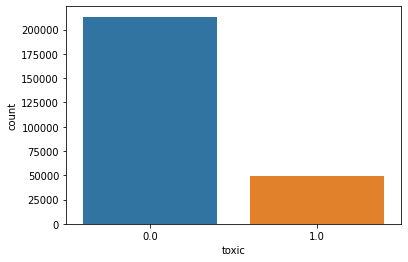

In [ ]:
# sns.countplot(x='toxic', data=data)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data.texts, data.toxic, test_size=0.05, random_state=42)

In [ ]:
# len(X_train), len(X_test), len(y_train), len(y_test)

(249566, 13136, 249566, 13136)

In [ ]:
# test_data = pd.DataFrame()
# test_data["texts"] = X_test
# test_data["toxic"] = y_test
# test_data.to_csv(test_data_path)

In [ ]:
# train_texts, valid_texts, train_targets, valid_targets = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
# len(train_texts), len(valid_texts)

(212131, 37435)

In [ ]:
# train_data = pd.DataFrame()
# train_data["texts"] = train_texts
# train_data["toxic"] = train_targets
# train_data.to_csv(train_data_path, index=False)

# valid_data = pd.DataFrame()
# valid_data["texts"] = valid_texts
# valid_data["toxic"] = valid_targets
# valid_data.to_csv(valid_data_path, index=False)

In [ ]:
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(valid_data_path)

train_texts = train_data["texts"]
train_targets = train_data["toxic"]
valid_texts = valid_data["texts"] 
valid_targets = valid_data["toxic"]

In [ ]:
tokenizer = WordPunctTokenizer().tokenize
def split_emojis(word, token="<EMJ>"):
    result = []
    detext = emoji.demojize(word)
    detext = re.sub(r"\:[\w]+\:", token, detext)
    num = token_in_word(detext, token)
    if num > 0:
        for n in range(num):
            result.append(token)
    else:
        result.append(detext)
    return result

def token_in_word(word, token):
    if token in word:
        return word.count(token)
    else:
        return 0

def tokenize_replace_emojis(text, tokenizer=tokenizer, token="<EMJ>"):
    result = []
    sentence = tokenizer(text)
    for word in sentence:
        word_in_list = split_emojis(word)
        for w in word_in_list:
            result.append(w)
    return result

In [ ]:
def tokenize_remove_emojis(text, tokenizer=tokenizer):
    result = []
    sentence = tokenizer(text)
    for word in sentence:
        detext = emoji.demojize(word)
        detext = re.sub(r"\:[\w]+\:", "", detext)
        if detext:
            result.append(detext)
    return result

In [ ]:
for text in data.texts[:20]:
    print(tokenize_replace_emojis(text))

['скотина', '!', 'что', 'сказать']
['я', 'сегодня', 'проезжала', 'по', 'рабочей', 'и', 'между', 'домами', 'снитенко', 'и', 'гомолысовой', 'магазином', '(', 'на', 'пустыре', ')', 'бежала', 'кошка', 'похожего', 'окраса', '.', 'может', ',', 'я', 'и', 'ошиблась', ',', 'но', 'необычный', 'окрас', 'бросился', 'в', 'глаза', '.']
['очередной', 'лохотрон', '.', 'зачем', 'придумывать', 'очередной', 'налог', 'на', 'воздух', ',', 'если', 'можно', 'обьявить', 'инсульт', 'и', 'грипп', '-', 'пандемией', '!', 'и', 'лихо', 'на', 'придурках', 'зарабатывать', 'годами', 'на', 'штрафах', ',', 'фейковых', 'вакцинах', ',', 'всевозможных', 'платных', 'тестах', ',', 'продажей', 'масок', 'и', 'перчаток', 'по', 'баснословным', 'ценам', '..', 'самое', 'смешное', ',', 'что', 'бараны', 'блеют', 'и', 'верят', 'пастуху', ',', 'телевизору', '.', 'живут', 'как', 'под', 'гипнозом', '.', 'не', 'думая', ',', 'не', 'глядя', 'по', 'сторонам', '.']
['ретро', 'дежавю', '...', 'сложно', 'понять', 'чужое', 'сердце', ',', 'лиш',

In [ ]:
for text in data.texts[:20]:
    print(tokenize_remove_emojis(text))

['скотина', '!', 'что', 'сказать']
['я', 'сегодня', 'проезжала', 'по', 'рабочей', 'и', 'между', 'домами', 'снитенко', 'и', 'гомолысовой', 'магазином', '(', 'на', 'пустыре', ')', 'бежала', 'кошка', 'похожего', 'окраса', '.', 'может', ',', 'я', 'и', 'ошиблась', ',', 'но', 'необычный', 'окрас', 'бросился', 'в', 'глаза', '.']
['очередной', 'лохотрон', '.', 'зачем', 'придумывать', 'очередной', 'налог', 'на', 'воздух', ',', 'если', 'можно', 'обьявить', 'инсульт', 'и', 'грипп', '-', 'пандемией', '!', 'и', 'лихо', 'на', 'придурках', 'зарабатывать', 'годами', 'на', 'штрафах', ',', 'фейковых', 'вакцинах', ',', 'всевозможных', 'платных', 'тестах', ',', 'продажей', 'масок', 'и', 'перчаток', 'по', 'баснословным', 'ценам', '..', 'самое', 'смешное', ',', 'что', 'бараны', 'блеют', 'и', 'верят', 'пастуху', ',', 'телевизору', '.', 'живут', 'как', 'под', 'гипнозом', '.', 'не', 'думая', ',', 'не', 'глядя', 'по', 'сторонам', '.']
['ретро', 'дежавю', '...', 'сложно', 'понять', 'чужое', 'сердце', ',', 'лиш',

In [ ]:
for text in data.texts[20:40]:
    print(tokenize_replace_emojis(text))

['жамь', 'что', 'мама', 'ефремова', 'нисделала', 'вовремя', 'оборт', '.']
['могу', 'повторить', '.', 'вы', 'живёте', 'в', 'россии', ',', 'не', 'оставляйте', 'российских', 'детей', 'без', 'вашей', 'заботы', '.']
['и', 'там', 'новый', 'кинотеатр', '?', 'фасад', 'сочинили', 'а', 'остальное', '?']
['кто', 'заседать', 'будет', '..????']
['долбоебы', 'это', 'фэйк']
['пиздаболы', ',', 'сделали', 'снимок', ',', 'придумали', 'историю', 'и', 'подали', 'дурачкам', 'через', 'сми']
['кто', 'этот', 'бред', 'пишет']
['да', '.', 'я', 'на', 'нем', 'за', '21', 'день', 'марафона', 'скинула', '5кг', 'и', 'обьемы', 'ушли', 'по', '8см', '.', 'а', 'потом', 'я', 'чего', 'то', 'расслабилась', 'в', 'принципе', 'как', 'всегда', 'и', 'все', '.', '((']
['пиши', 'сразу', 'путину', 'раз', 'такая', 'смелая']
['пока', 'хвалиться', 'нечем', ',', 'не', 'очень', 'хочется', 'затевать', 'ремонт', 'в', 'зале', 'и', 'в', 'коридоре', '.', 'сейчас', 'много', 'работы', 'на', 'огороде', '.']
['батька', 'с', 'огнем', 'играет']
['

In [ ]:
for text in data.texts[20:40]:
    print(tokenize_remove_emojis(text))

['жамь', 'что', 'мама', 'ефремова', 'нисделала', 'вовремя', 'оборт', '.']
['могу', 'повторить', '.', 'вы', 'живёте', 'в', 'россии', ',', 'не', 'оставляйте', 'российских', 'детей', 'без', 'вашей', 'заботы', '.']
['и', 'там', 'новый', 'кинотеатр', '?', 'фасад', 'сочинили', 'а', 'остальное', '?']
['кто', 'заседать', 'будет', '..????']
['долбоебы', 'это', 'фэйк']
['пиздаболы', ',', 'сделали', 'снимок', ',', 'придумали', 'историю', 'и', 'подали', 'дурачкам', 'через', 'сми']
['кто', 'этот', 'бред', 'пишет']
['да', '.', 'я', 'на', 'нем', 'за', '21', 'день', 'марафона', 'скинула', '5кг', 'и', 'обьемы', 'ушли', 'по', '8см', '.', 'а', 'потом', 'я', 'чего', 'то', 'расслабилась', 'в', 'принципе', 'как', 'всегда', 'и', 'все', '.', '((']
['пиши', 'сразу', 'путину', 'раз', 'такая', 'смелая']
['пока', 'хвалиться', 'нечем', ',', 'не', 'очень', 'хочется', 'затевать', 'ремонт', 'в', 'зале', 'и', 'в', 'коридоре', '.', 'сейчас', 'много', 'работы', 'на', 'огороде', '.']
['батька', 'с', 'огнем', 'играет']
['

In [ ]:
len_with_emoji = [len(tokenize_replace_emojis(x)) for x in data.texts]
len_no_emoji = [len(tokenize_remove_emojis(x)) for x in data.texts]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


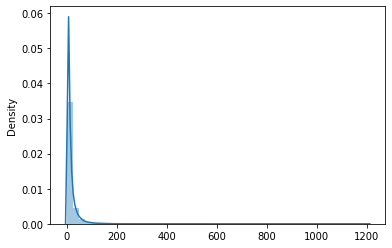

In [ ]:
sns.distplot(len_with_emoji)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


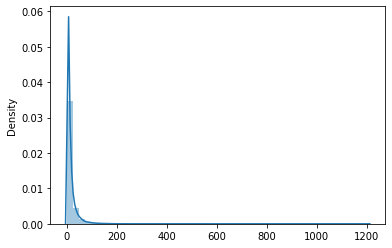

In [ ]:
sns.distplot(len_no_emoji)

In [ ]:
np.mean(len_with_emoji)

16.571388874085464

In [ ]:
np.mean(len_no_emoji)

16.374055012904357

In [ ]:
np.max(len_with_emoji)

1207

In [ ]:
np.max(len_no_emoji)

1207

In [ ]:
max_len_with_emoji = 30
max_len_no_emoji = 30

## Эмбеддинги

In [ ]:
fasttext = KeyedVectors.load(vector_model_path)

In [ ]:
def get_vocab_embeddings(texts, tokenizer, vector_model=fasttext):
    vocab = {'<PAD>': 0}
    embeddings = [np.zeros(300)]
    
    for sentence in tqdm_notebook(texts):
        words = tokenizer(sentence)
        for word in words:
            if word not in vocab:
                vocab[word] = len(vocab)
                embeddings.append(vector_model[word])
    return vocab, embeddings

In [ ]:
word_to_id_with_emoji, embeddings = get_vocab_embeddings(data.texts, tokenize_replace_emojis)

In [ ]:
embeddings = torch.tensor(embeddings).float()

In [ ]:
json_dump = json.dumps(word_to_id_with_emoji)
f = open(toxic_emj_vocab_path, "w")
f.write(json_dump)
f.close()  

## Определение токсичности текста с заменой эмодзи на специальный токен

Обработчик данных с заменой эмодзи на специальный токен

In [ ]:
class BaddEMJTextClassifierDataset(Dataset):
    
    def __init__(self, texts, targets, word_to_id, tokenizer, token, pad_index=0, max_len=None):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = word_to_id
        self.tokenizer = tokenizer
        self.token = token
        self.pad_index = pad_index
        self.max_len = max_len
        
    def __len__(self):

        return len(self.texts)

    def split_emojis(self, word):
        result = []
        detext = emoji.demojize(word)
        detext = re.sub(r"\:[\w]+\:", self.token, detext)
        num = self.token_in_word(detext)
        if num > 0:
            for n in range(num):
                result.append(self.token)
        else:
            result.append(detext)
        return result

    def token_in_word(self, word):
        if self.token in word:
            return word.count(self.token)
        else:
            return 0

    def tokenization(self, text):
        result = []
        sentence = self.tokenizer(text)
        for word in sentence:
            word_in_list = self.split_emojis(word)
            for w in word_in_list:
                result.append(w)
        return result

    def get_text_indeces(self, tokenized_text):

        return [self.vocab[token] for token in tokenized_text if token in self.vocab]

    def padding(self, sequence):

        padds = [self.pad_index] * (self.max_len - len(sequence))
        sequence = sequence + padds
        return sequence
    
    def __getitem__(self, index):
       
        text = self.texts[index][:self.max_len]      
        tokenized_text = self.tokenization(text)
        indeces_of_text = self.get_text_indeces(tokenized_text)
        padded_text = self.padding(indeces_of_text)
        converted_text = torch.tensor(padded_text)

        target = self.targets[index]

        return converted_text, target

In [ ]:
train_dataset = BaddEMJTextClassifierDataset(train_texts, train_targets, word_to_id_with_emoji, tokenizer, "<EMJ>", pad_index=0, max_len=max_len_with_emoji)
valid_dataset = BaddEMJTextClassifierDataset(valid_texts, valid_targets, word_to_id_with_emoji, tokenizer, "<EMJ>", pad_index=0, max_len=max_len_with_emoji)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
for x, y in train_loader:
    break

In [ ]:
x[0]

tensor([ 1355,  7372,    74, 13023,   329,   924,   381,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
y[0]

tensor(1., dtype=torch.float64)

In [ ]:
device = torch.device('cpu')

In [ ]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [ ]:
class BaddEMJToxicLSTM(torch.nn.Module):
    
    def __init__(self, embeddings, vocab_size, num_classes, embedding_dim, hidden_dim, num_lstm_layers, linear_size, padding_idx):
        
        super().__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=padding_idx, freeze=False)

        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=hidden_dim,
                                  num_layers=num_lstm_layers, 
                                  batch_first=True,
                                  bidirectional=False)
        

        self.relu = nn.ReLU()
        
        self.output_layer = torch.nn.Linear(in_features=hidden_dim,
                                            out_features=num_classes,
                                            bias=False)

        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.relu(x)
        x = self.output_layer(x)
        
        return x

In [ ]:
vocab_size = len(word_to_id_with_emoji)
num_classes = 1
embedding_dim = 300
hidden_dim = 254
num_lstm_layers = 8
linear_size = 128
padding_idx = 0

In [ ]:
toxic_model_emj = BaddEMJToxicLSTM(embeddings,
                                   vocab_size, 
                                   num_classes, 
                                   embedding_dim, 
                                   hidden_dim, 
                                   num_lstm_layers, 
                                   linear_size, 
                                   padding_idx)

toxic_model_emj.to(device)

BaddEMJToxicLSTM(
  (embedding_layer): Embedding(286256, 300, padding_idx=0)
  (lstm): LSTM(300, 254, num_layers=8, batch_first=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=254, out_features=1, bias=False)
)

In [ ]:
def train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average, clip=3.0):

    train_losses = []
    f_scores_train = []

    model.train()
    
    train_progress_bar = tqdm_notebook(total=len(train_loader.dataset), desc=f'Epoch: {n_epoch + 1}, train', position=0, leave=True)
    

    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
            
        pred = model(x.detach())

        f_scores_train.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        
        loss = criterion(pred.cpu().squeeze(), y.cpu())

        # loss = loss * weights[y.cpu().view(-1)]
        # loss = loss.mean()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())

        train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
        train_progress_bar.update(x.shape[0])

    train_progress_bar.close()

    return train_losses, f_scores_train

In [ ]:
def validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average):

    valid_losses = []
    f_scores_valid = []

    model.eval()

    valid_progress_bar = tqdm_notebook(total=len(valid_loader.dataset), desc=f'Epoch: {n_epoch + 1}, validation', position=0, leave=True)

    for x, y in valid_loader:

        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():  
            pred = model(x.detach())

        f_scores_valid.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        loss = criterion(pred.cpu().squeeze(), y.cpu())

        # loss = loss * weights[y.cpu().view(-1)]
        # loss = loss.mean()

        valid_losses.append(loss.item())

        valid_progress_bar.set_postfix(valid_loss = np.mean(valid_losses[-500:]))
        valid_progress_bar.update(x.shape[0])
    
    valid_progress_bar.close()

    return valid_losses, f_scores_valid

In [ ]:
def binarize(pred):
    pred = pred.cpu().detach().numpy()
    result = []
    for r in pred:
        if r <= 0.5:
            result.append(0.)
        else:
            result.append(1.)
    return result

In [ ]:
def save_model(model, optimizer, path_to_model_state, path_to_optimizer_state):
    torch.save(model.state_dict(), path_to_model_state)
    torch.save(optimizer.state_dict(), path_to_optimizer_state)
    
def load_model(path_to_model_state, path_to_optimizer_state):
    model_state = torch.load(path_to_model_state)
    optimizer_state = torch.load(path_to_optimizer_state)
    return model_state, optimizer_state

In [ ]:
def train_and_validate(model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       best_model_state_path,
                       best_opt_state_path,
                       last_model_state_path,
                       last_opt_state_path):

    val_losses = []
    tr_losses = []
    mean_f_scores_train = []
    mean_f_scores_valid = []
    best_val_loss = 10.0

    for n_epoch in range(n_epochs):

        epoch_train_losses, f_scores_train = train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average)
        epoch_valid_losses, f_scores_valid = validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average)

        mean_epoch_val_loss = np.mean(epoch_valid_losses)
        mean_f_scores_train.append(np.mean(f_scores_train))
        mean_f_scores_valid.append(np.mean(f_scores_valid))
        val_losses.append(mean_epoch_val_loss)
        tr_losses.append(np.mean(epoch_train_losses))

        scheduler.step()

        if mean_epoch_val_loss < best_val_loss:
            best_val_loss = mean_epoch_val_loss
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, best_model_state_path, best_opt_state_path)
        else:
            print(f'Early stopping on epoch {n_epoch+1}')
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, last_model_state_path, last_opt_state_path)
            break

    return val_losses, tr_losses, mean_f_scores_train, mean_f_scores_valid

In [ ]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', toxic_model_emj.named_parameters()))]
embedding_params = toxic_model_emj.embedding_layer.parameters()
f_score_average = "micro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(toxic_model_emj,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       toxic_model_emj_best_state_path,
                       toxic_opt_emj_best_state_path,
                       toxic_model_emj_last_state_path,
                       toxic_opt_emj_last_state_path)


F-score on validation: 0.8939394487186904



F-score on validation: 0.9179197156823047



F-score on validation: 0.9211058165095158



Early stopping on epoch 4
F-score on validation: 0.9198304723202407
CPU times: user 11min 3s, sys: 4min 38s, total: 15min 41s
Wall time: 15min 51s


In [ ]:
def show_f_scores_graph(f_scores, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(f_scores)
    plt.grid()
    if training:
      plt.title('F-scores on train')
    else:
      plt.title('F-scores on validation')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('f-score')

In [ ]:
def show_losses_graph(losses, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(losses)
    plt.grid()
    if training:
      plt.title('Training process')
    else:
      plt.title('Validation process')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('Loss function')

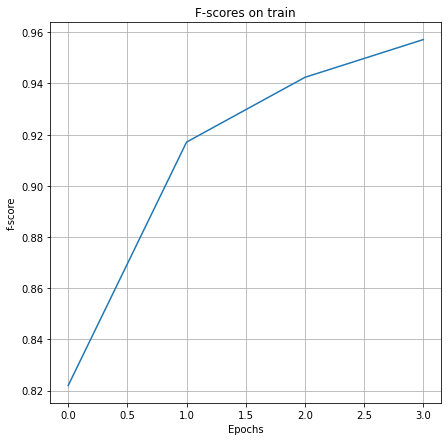

In [ ]:
show_f_scores_graph(mean_f_scores_train, training=True)

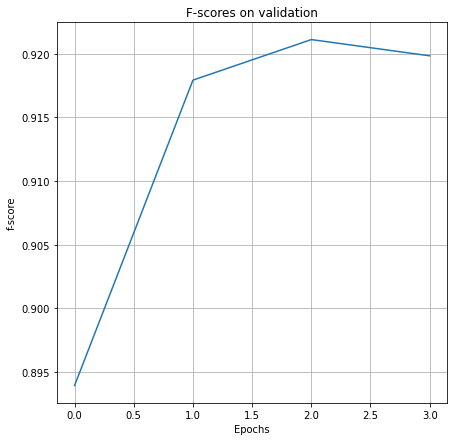

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=False)

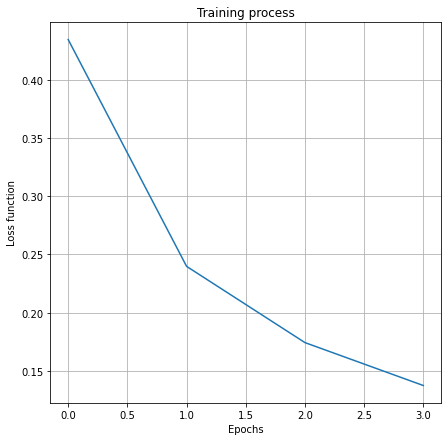

In [ ]:
show_losses_graph(train_losses, training=True)

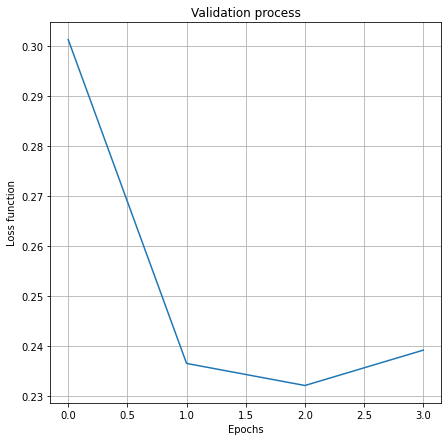

In [ ]:
show_losses_graph(valid_losses, training=False)

In [ ]:
test_data = pd.read_csv(test_data_path)

In [ ]:
model, _ = load_model(toxic_model_emj_best_state_path, toxic_opt_emj_best_state_path)
toxic_model_emj.load_state_dict(model)

<All keys matched successfully>

In [ ]:
def predict_text(text, model, tokenizer, vocab, max_len):
    tokenized_text = tokenizer(text.lower())
    ids = [vocab[token] for token in tokenized_text if token in vocab]
    padds = [0] * (max_len - len(ids))
    padded_ids = ids + padds
    tensor_ids = torch.tensor(padded_ids)
    tensor_ids = torch.unsqueeze(tensor_ids,0)
    
    with torch.no_grad():
      pred = model.forward(tensor_ids.to(device))
      pred = binarize(pred)
      return pred[0]

In [ ]:
def make_preds(model, texts, tokenizer, vocab, max_len):
    model.eval()
    y_preds = []
    for text in texts:
        y_preds.append(predict_text(text, model, tokenizer, vocab, max_len))
    return y_preds

In [ ]:
%%time
y_preds = make_preds(toxic_model_emj, test_data.texts, tokenize_replace_emojis, word_to_id_with_emoji, max_len_with_emoji)
y_trues = test_data.toxic

CPU times: user 3min 6s, sys: 1min 45s, total: 4min 51s
Wall time: 4min 50s


In [ ]:
def evaluate_on_texts(y_trues, y_preds, f_score_average = "macro"):
    
    print(f"F1 score: {f1_score(y_trues, y_preds, average=f_score_average)}")
    print(f"Accuracy: {accuracy_score(y_trues, y_preds)}")
    print(classification_report(y_trues, y_preds))

In [ ]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.8757561973684129
Accuracy: 0.933084652862363
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     10675
         1.0       0.95      0.68      0.79      2461

    accuracy                           0.93     13136
   macro avg       0.94      0.83      0.88     13136
weighted avg       0.93      0.93      0.93     13136



## Определение токсичности текстов без эмодзи

In [ ]:
word_to_id_no_emoji, embeddings = get_vocab_embeddings(data.texts, tokenize_remove_emojis)

In [ ]:
embeddings = torch.tensor(embeddings).float()

In [ ]:
json_dump = json.dumps(word_to_id_no_emoji)
f = open(toxic_vocab_path, "w")
f.write(json_dump)
f.close()  

Обработчик данных с удалением эмодзи

In [ ]:
class BaddTextClassifierDataset(Dataset):
    
    def __init__(self, texts, targets, word_to_id, tokenizer, pad_index=0, max_len=None):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = word_to_id
        self.tokenizer = tokenizer
        self.pad_index = pad_index
        self.max_len = max_len
        
    def __len__(self):

        return len(self.texts)

    def tokenization(self, text):
        
        result = []
        sentence = self.tokenizer(text)
        for word in sentence:
            detext = emoji.demojize(word)
            detext = re.sub(r"\:[\w]+\:", "", detext)
            if detext:
                result.append(detext)
        return result

    def get_text_indeces(self, tokenized_text):

        return [self.vocab[token] for token in tokenized_text if token in self.vocab]

    def padding(self, sequence):

        padds = [self.pad_index] * (self.max_len - len(sequence))
        sequence = sequence + padds
        return sequence
    
    def __getitem__(self, index):
       
        text = self.texts[index][:self.max_len]      
        tokenized_text = self.tokenization(text)
        indeces_of_text = self.get_text_indeces(tokenized_text)
        padded_text = self.padding(indeces_of_text)
        converted_text = torch.tensor(padded_text)

        target = self.targets[index]

        return converted_text, target

In [ ]:
train_dataset = BaddTextClassifierDataset(train_texts, train_targets, word_to_id_no_emoji, tokenizer, pad_index=0, max_len=max_len_no_emoji)
valid_dataset = BaddTextClassifierDataset(valid_texts, valid_targets, word_to_id_no_emoji, tokenizer, pad_index=0, max_len=max_len_no_emoji)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
for x, y in train_loader:
    break

In [ ]:
x

tensor([[     5,    706,    477,  ...,      0,      0,      0],
        [   833,  59016, 246356,  ...,      0,      0,      0],
        [   167,    491,    492,  ...,      0,      0,      0],
        ...,
        [  4211,  30586,   6135,  ...,      0,      0,      0],
        [209486, 179494,  13934,  ...,      0,      0,      0],
        [   214,      3,     32,  ...,      0,      0,      0]])

In [ ]:
y

tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        0., 0.], dtype=torch.float64)

In [ ]:
device = torch.device('cpu')

In [ ]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [ ]:
class BaddToxicLSTM(torch.nn.Module):
    
    def __init__(self, embeddings, vocab_size, num_classes, embedding_dim, hidden_dim, num_lstm_layers, linear_size, padding_idx):
        
        super().__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=padding_idx, freeze=False)

        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=hidden_dim,
                                  num_layers=num_lstm_layers, 
                                  batch_first=True,
                                  bidirectional=False)
        

        self.relu = nn.ReLU()
        
        self.output_layer = torch.nn.Linear(in_features=hidden_dim,
                                            out_features=num_classes,
                                            bias=False)

        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.relu(x)
        x = self.output_layer(x)
        
        return x

In [ ]:
vocab_size = len(word_to_id_no_emoji)
num_classes = 1
embedding_dim = 300
hidden_dim = 254
num_lstm_layers = 8
linear_size = 128
padding_idx = 0

In [ ]:
toxic_model = BaddToxicLSTM(embeddings,
                                   vocab_size, 
                                   num_classes, 
                                   embedding_dim, 
                                   hidden_dim, 
                                   num_lstm_layers, 
                                   linear_size, 
                                   padding_idx)

toxic_model.to(device)

BaddToxicLSTM(
  (embedding_layer): Embedding(286444, 300, padding_idx=0)
  (lstm): LSTM(300, 254, num_layers=8, batch_first=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=254, out_features=1, bias=False)
)

In [ ]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', toxic_model.named_parameters()))]
embedding_params = toxic_model.embedding_layer.parameters()
f_score_average = "micro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(toxic_model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       toxic_model_best_state_path,
                       toxic_opt_best_state_path,
                       toxic_model_last_state_path,
                       toxic_opt_last_state_path)


F-score on validation: 0.8897134588129809



F-score on validation: 0.9167284303233643



F-score on validation: 0.9216214677214091



Early stopping on epoch 4
F-score on validation: 0.919750480852664
CPU times: user 6min 11s, sys: 1min 4s, total: 7min 15s
Wall time: 7min 30s


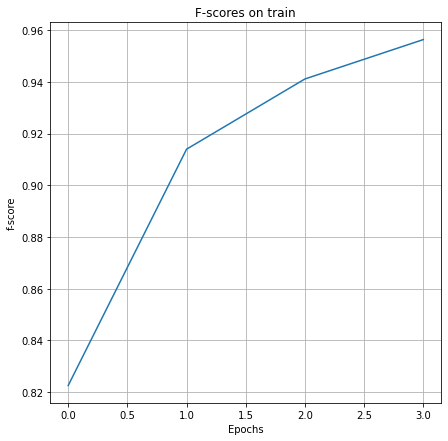

In [ ]:
show_f_scores_graph(mean_f_scores_train, training=True)

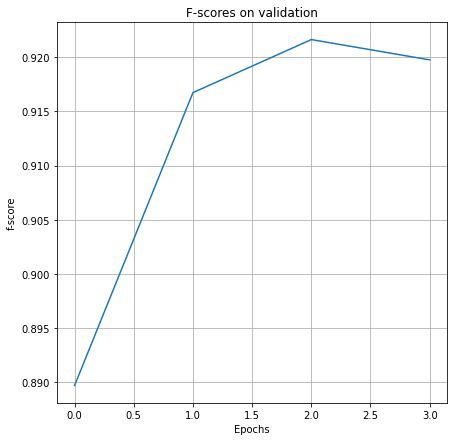

In [ ]:
show_f_scores_graph(mean_f_scores_valid, training=False)

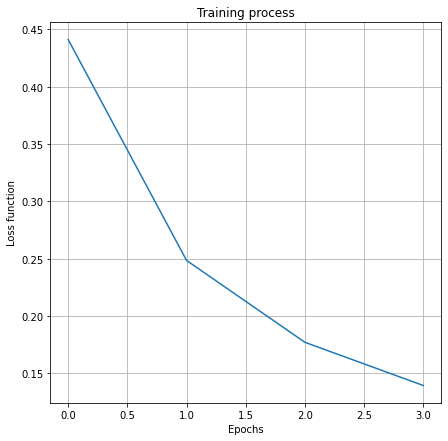

In [ ]:
show_losses_graph(train_losses, training=True)

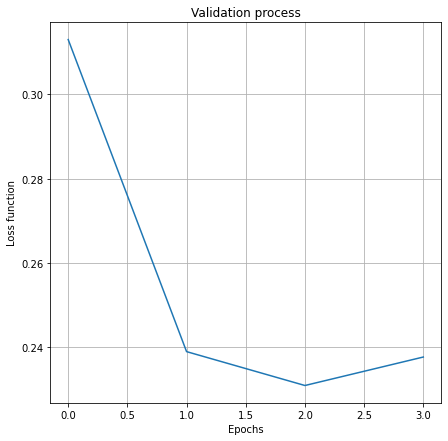

In [ ]:
show_losses_graph(valid_losses, training=False)

In [ ]:
test_data = pd.read_csv(test_data_path)

In [ ]:
model, _ = load_model(toxic_model_best_state_path, toxic_opt_best_state_path)
toxic_model.load_state_dict(model)

<All keys matched successfully>

In [ ]:
%%time
y_preds = make_preds(toxic_model, test_data.texts, tokenize_remove_emojis, word_to_id_no_emoji, max_len_no_emoji)
y_trues = test_data.toxic

CPU times: user 1min 6s, sys: 17.4 s, total: 1min 23s
Wall time: 1min 23s


In [ ]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.879560920907829
Accuracy: 0.9338459196102314
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     10675
         1.0       0.93      0.70      0.80      2461

    accuracy                           0.93     13136
   macro avg       0.93      0.84      0.88     13136
weighted avg       0.93      0.93      0.93     13136



## Выводы

С небольшим отрывом побеждает модель, токенизация данных для которой содержит функцию удаления эмодзи из текстов.